## Mnist

In [37]:
from models import VAE
from losses import VAE_Loss
import torch

In [38]:
# Example usage
input_shape = (3, 64, 64)  # Assuming RGB images of size 64x64
output_shape = (3, 64, 64)  # Same as input_shape
hidden_dims = [32, 64, 128]  # Hidden dimensions
latent_dim = 100  # Latent dimension

vae = VAE(input_shape, hidden_dims, latent_dim, output_shape)

In [39]:
batch_size = 32
x = torch.sigmoid(torch.randn(batch_size, *input_shape))

In [40]:
reconstructed, mu, logvar = vae.forward(
    x
)  # x is a torch.Tensor of shape (batch_size, *input_shape)
reconstructed.shape, mu.shape, logvar.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 100]), torch.Size([32, 100]))

Minimum value of x: 0.009992982260882854
Maximum value of x: 0.9868453741073608
Minimum value of reconstructed: 0.003178034909069538
Maximum value of reconstructed: 0.9980390667915344


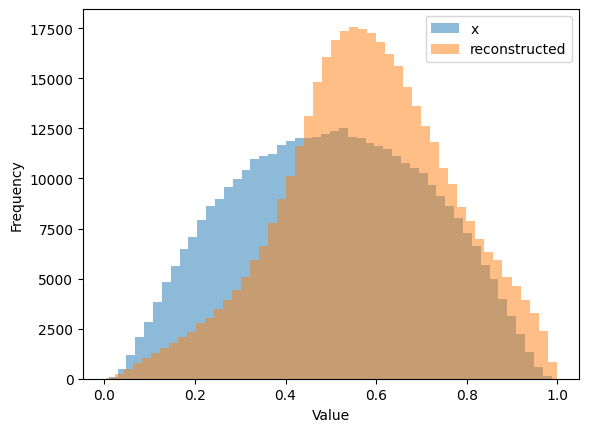

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Compare minimum and maximum values
x_min = torch.min(x).item()
x_max = torch.max(x).item()
reconstructed_min = torch.min(reconstructed).item()
reconstructed_max = torch.max(reconstructed).item()

print("Minimum value of x:", x_min)
print("Maximum value of x:", x_max)
print("Minimum value of reconstructed:", reconstructed_min)
print("Maximum value of reconstructed:", reconstructed_max)

# Compare distributions
x_values = x.flatten().detach().numpy()
reconstructed_values = reconstructed.flatten().detach().numpy()

plt.hist(x_values, bins=50, alpha=0.5, label='x')
plt.hist(reconstructed_values, bins=50, alpha=0.5, label='reconstructed')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [42]:
total_loss, recon_loss, regul_loss = VAE_Loss(x, reconstructed, mu, logvar)
print("Total loss:", total_loss.item())
print("Reconstruction loss:", recon_loss.item())
print("Regularization loss:", regul_loss.item())

Total loss: 317436.40625
Reconstruction loss: 317027.5
Regularization loss: 408.9064025878906


In [43]:
import torchvision
import torchvision.transforms as transforms

# Define data transformation
transform = transforms.ToTensor()

# Load MNIST train and test datasets
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

class_label = 8  # Class label for digit 8
# Filter train dataset for class class_label
train_dataset_filtered = torch.utils.data.Subset(
    train_dataset,
    [i for i, (_, label) in enumerate(train_dataset) if label == class_label],
)

# Filter test dataset for class class_label
test_dataset_filtered = torch.utils.data.Subset(
    test_dataset,
    [i for i, (_, label) in enumerate(test_dataset) if label == 9],
)

# # Create data loaders for filtered datasets
# train_loader_filtered = torch.utils.data.DataLoader(train_dataset_filtered, batch_size=64, shuffle=True)
# test_loader_filtered = torch.utils.data.DataLoader(test_dataset_filtered, batch_size=64, shuffle=False)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset_filtered, batch_size=64, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset_filtered, batch_size=64, shuffle=False
)

In [44]:
from tqdm import tqdm
# Function to train the VAE model
def train_vae(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch_idx, (data, _) in enumerate(progress_bar):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, _, _ = VAE_Loss(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            progress_bar.set_postfix({"Loss": loss.item() / len(data)})
        print(
            "====> Epoch: {} Average loss: {:.4f}".format(
                epoch, total_loss / len(train_loader.dataset)
            )
        )

In [45]:
# Train the VAE model
vae_mnist = VAE(
    input_shape=(1, 28, 28),
    hidden_dims=[32, 64, 128],
    latent_dim=20,
    output_shape=(1, 28, 28),
)
vae_mnist

VAE(
  (encoder): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=2048, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=20, bias=True)
  (decoder): Sequential(
    (fc): Linear(in_features=20, out_features=2048, bias=True)
    (relu): ReLU()
    (reshape): Unflatten(dim=1, unflattened_size=(128, 4, 4))
    (conv_transpose1): ConvTranspose2d(128, 12

In [46]:
optimizer = torch.optim.Adam(vae_mnist.parameters(), lr=1e-3)
num_epochs = 40
train_vae(vae_mnist, train_loader, optimizer, num_epochs=num_epochs)

====> Epoch: 0 Average loss: 237.5866


====> Epoch: 1 Average loss: 147.8553


====> Epoch: 2 Average loss: 130.8194


====> Epoch: 3 Average loss: 124.2478


====> Epoch: 4 Average loss: 120.1660


====> Epoch: 5 Average loss: 117.9821


====> Epoch: 6 Average loss: 116.4651


====> Epoch: 7 Average loss: 114.7994


====> Epoch: 8 Average loss: 113.8213


====> Epoch: 9 Average loss: 113.0269


====> Epoch: 10 Average loss: 112.3894


====> Epoch: 11 Average loss: 111.8335


====> Epoch: 12 Average loss: 110.9785


====> Epoch: 13 Average loss: 110.5008


====> Epoch: 14 Average loss: 110.4187


====> Epoch: 15 Average loss: 109.7843


====> Epoch: 16 Average loss: 109.2872


====> Epoch: 17 Average loss: 108.9648


====> Epoch: 18 Average loss: 108.7896


====> Epoch: 19 Average loss: 108.4863


====> Epoch: 20 Average loss: 108.2461


====> Epoch: 21 Average loss: 107.9392


====> Epoch: 22 Average loss: 107.7848


====> Epoch: 23 Average loss: 107.4129


====> Epoch: 24 Average loss: 107.3438


====> Epoch: 25 Average loss: 107.0731


====> Epoch: 26 Average loss: 106.7082


====> Epoch: 27 Average loss: 106.6791


====> Epoch: 28 Average loss: 106.4343


====> Epoch: 29 Average loss: 106.3804


====> Epoch: 30 Average loss: 106.0000


====> Epoch: 31 Average loss: 105.8693


====> Epoch: 32 Average loss: 105.7267


====> Epoch: 33 Average loss: 105.4775


====> Epoch: 34 Average loss: 105.5189


====> Epoch: 35 Average loss: 105.3230


====> Epoch: 36 Average loss: 105.2069


====> Epoch: 37 Average loss: 105.0563


====> Epoch: 38 Average loss: 104.8949


====> Epoch: 39 Average loss: 105.0746


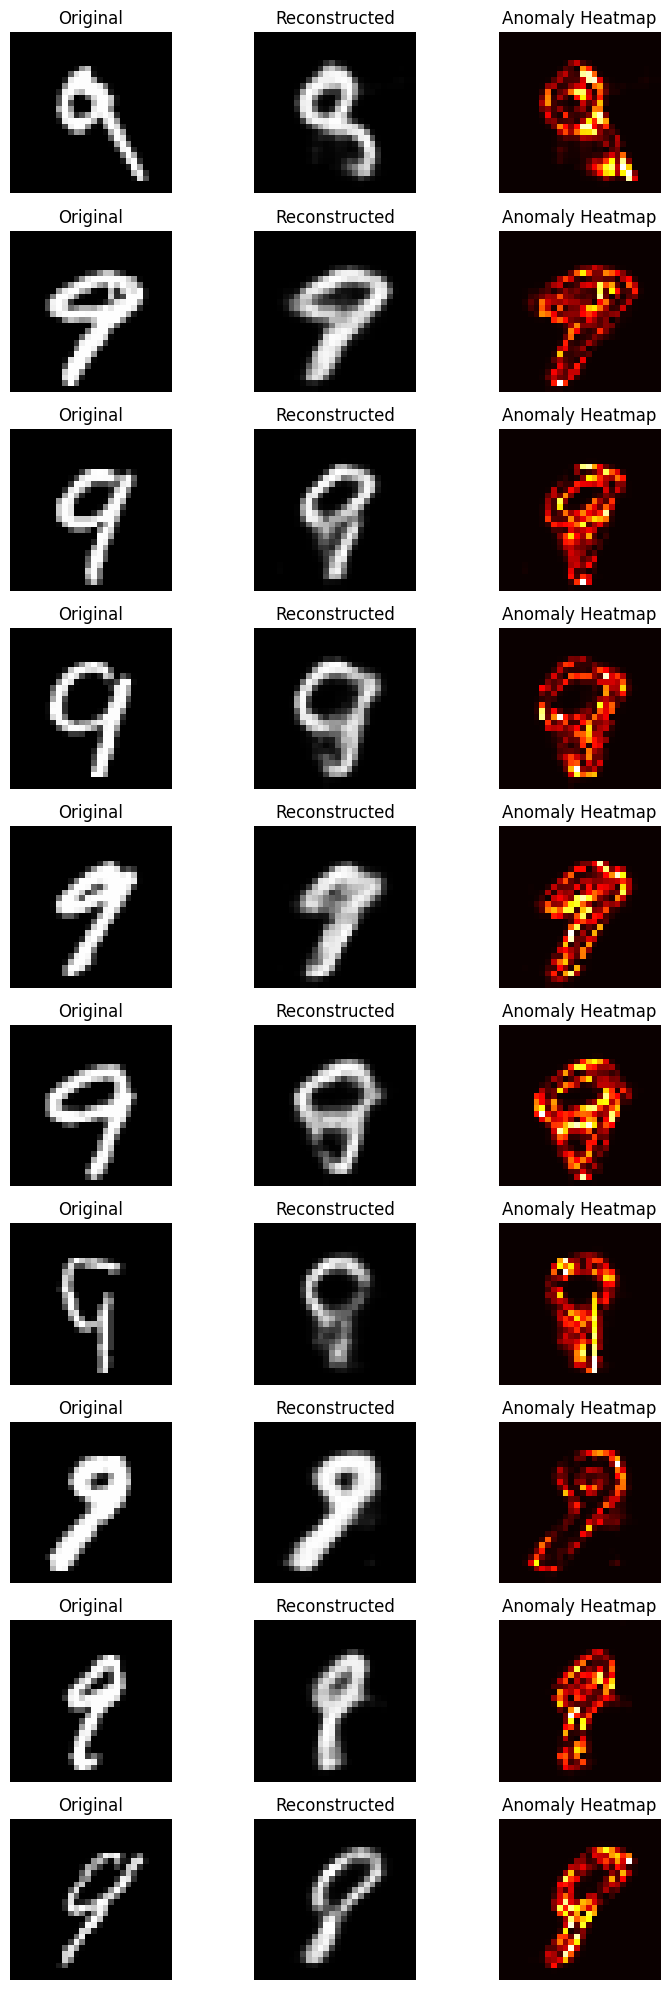

In [47]:
def plot_reconstructed_images_with_anomaly(model, test_loader, num_images=10):
    # Set the model to evaluation mode
    model.eval()

    # Sample a batch of images from the test loader
    images, _ = next(iter(test_loader))
    images = images[:num_images]

    # Generate reconstructed images using the model
    with torch.no_grad():
        reconstructed, _, _ = model(images)

    # Calculate the absolute difference between the original and reconstructed images
    diff = torch.abs(images - reconstructed)

    # Calculate the anomaly heatmap by summing the absolute differences across channels
    anomaly_heatmap = torch.sum(diff, dim=1, keepdim=True)

    # Plot the original, reconstructed, and anomaly heatmap images side by side
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2*num_images))
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')

        # Plot reconstructed image
        axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Reconstructed')

        # Plot anomaly heatmap
        axes[i, 2].imshow(anomaly_heatmap[i].squeeze(), cmap='hot')
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Anomaly Heatmap')

    plt.tight_layout()
    plt.show()

# Call the function to plot reconstructed images with anomaly heatmap
plot_reconstructed_images_with_anomaly(vae_mnist, test_loader)


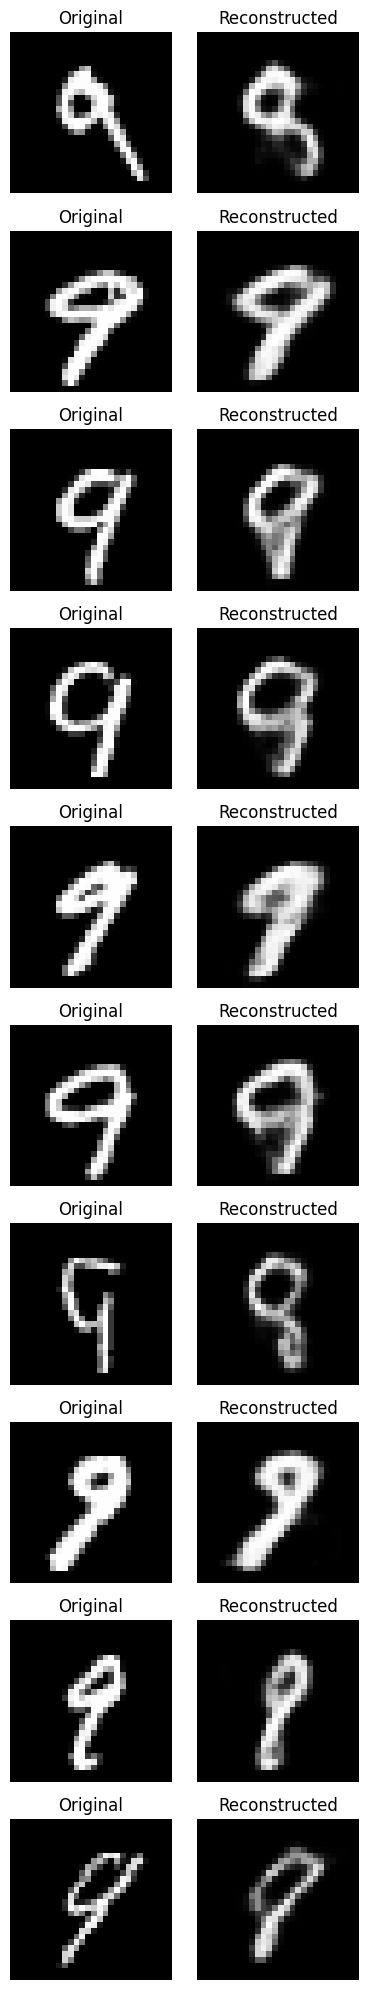

In [48]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_reconstructed_images(model, test_loader, num_images=10):
    # Set the model to evaluation mode
    model.eval()

    # Sample a batch of images from the test loader
    images, _ = next(iter(test_loader))
    images = images[:num_images]

    # Generate reconstructed images using the model
    with torch.no_grad():
        reconstructed, _, _ = model(images)

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(num_images, 2, figsize=(4, 2*num_images))
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')

        # Plot reconstructed image
        axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Call the function to plot reconstructed images
plot_reconstructed_images(vae_mnist, test_loader)


## Brain-MRI

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from PIL import Image

import os
import time
import random
import tqdm

import pandas as pd

from models import VAE
from losses import VAE_Loss

In [2]:
ROOT_DIR_TRAIN = r"C:\Users\hp\Desktop\DH602\Project\Coding\Brain-MRIdata\Training"
ROOT_DIR_TEST = r"C:\Users\hp\Desktop\DH602\Project\Coding\Brain-MRIdata\Testing"


IMAGE_SIZE = (128, 128)
IMAGE_CHANNELS = 1

INPUT_SHAPE = (IMAGE_CHANNELS, *IMAGE_SIZE)
OUTPUT_SHAPE = (IMAGE_CHANNELS, *IMAGE_SIZE)
HIDDEN_DIMS = [32, 64, 128]
LATENT_DIM = 100

OUTPUT_DIR = r"C:\Users\hp\Desktop\DH602\Project\Coding\output"
BATCH_SIZE = 32
NUM_EPOCHS = 1
LEARNING_RATE = 1e-3
SAVE_AFTER_K = 1
VALIDATE_AFTER_K = 1


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def create_data_df(root_dir, mappings=None):
    '''
    1. assumes that there are subfolder of each class in the root directory 
    2. it labels each subfolder as a class and assigns the images in the subfolder to that class
    3. if there are no subfolders, it assumes that the images in the root directory belong to class 0

    it return Dataframe and an dictionary of subfolder ans class labels mappings
    '''

    image_paths = []
    labels = []
    label_mappings = {}

    # check if root has subfolders
    if len(os.listdir(root_dir)) == 0:
        print("No subfolders found, assuming all images in root directory belong to class 0")
        label_mappings[os.path.basename(root_dir)] = 0
        for image_file in os.listdir(root_dir):
            image_path = os.path.join(root_dir, image_file)
            image_paths.append(image_path)
            labels.append(0)
    else:
        for i, subdir in enumerate(os.listdir(root_dir)):
            label_mappings[os.path.basename(subdir)] = i
            subdir_path = os.path.join(root_dir, subdir)
            for image_file in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, image_file)
                image_paths.append(image_path)
                if mappings:
                    labels.append(mappings[subdir])
                else:
                    labels.append(i)
    if mappings:
        label_mappings = mappings
    return pd.DataFrame({"image_path": image_paths, "label": labels}), label_mappings

train_df, label_mappings = create_data_df(ROOT_DIR_TRAIN)   
test_df, _ = create_data_df(ROOT_DIR_TEST, mappings=label_mappings)

train_df.head(2), test_df.head(2), label_mappings

(                                          image_path  label
 0  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0
 1  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0,
                                           image_path  label
 0  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0
 1  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0,
 {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3})

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        image_path, label = (
            self.data_df.iloc[index]["image_path"],
            self.data_df.iloc[index]["label"],
        )
        image = Image.open(image_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Create a dataset object for the images without tumor
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Grayscale(),
        torchvision.transforms.Resize(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
    ]
)

# creating no tumor dataset, dataloader
no_tumor_df = train_df[train_df['label'] == label_mappings['notumor']]
no_tumor_dataset = CustomDataset(no_tumor_df, transform=transform)
no_tumor_data_loader = DataLoader(no_tumor_dataset, batch_size=BATCH_SIZE, shuffle=True)

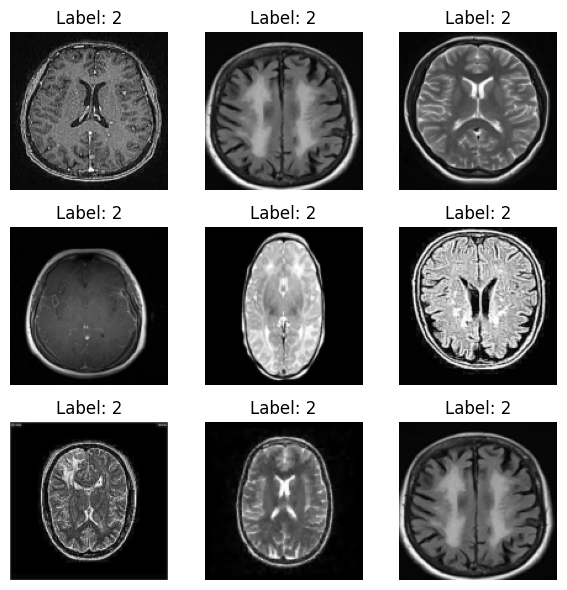

In [6]:
def show_images_grid(dataset, num_images=9, grid_size=(3, 3)):
    fig, axes = plt.subplots(*grid_size, figsize=(2*grid_size[0], 2*grid_size[1]))
    sampled_indices = random.sample(range(len(dataset)), num_images)
    for i, ax in enumerate(axes.flat):
        image, label = dataset[sampled_indices[i]]
        ax.imshow(image.permute(1, 2, 0), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {label}")
    plt.tight_layout()
    plt.show()

# Assuming you have a dataset object named 'custom_dataset'
show_images_grid(no_tumor_dataset, num_images=9, grid_size=(3, 3))

In [7]:
model = VAE(
    input_shape=INPUT_SHAPE,
    hidden_dims=HIDDEN_DIMS,
    latent_dim=LATENT_DIM,
    output_shape=OUTPUT_SHAPE
)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = VAE_Loss

In [8]:
model

VAE(
  (encoder): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=32768, out_features=100, bias=True)
  (fc_logvar): Linear(in_features=32768, out_features=100, bias=True)
  (decoder): Sequential(
    (fc): Linear(in_features=100, out_features=32768, bias=True)
    (relu): ReLU()
    (reshape): Unflatten(dim=1, unflattened_size=(128, 16, 16))
    (conv_transpose1): ConvTranspose2d

In [13]:
def get_reconstructed_images(model, images, cmap='gray'):
    num_images = images.size(0)
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(images)

    # Calculate the absolute difference between the original and reconstructed images
    diff = torch.abs(images - reconstructed)

    # Calculate the anomaly heatmap by summing the absolute differences across channels
    anomaly_heatmap = torch.sum(diff, dim=1, keepdim=True)

    # Plot the original, reconstructed, and anomaly heatmap images side by side
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2 * num_images));
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0), cmap=cmap)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original")

        # Plot reconstructed image
        axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0), cmap=cmap)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Reconstructed")

        # Plot anomaly heatmap
        axes[i, 2].imshow(anomaly_heatmap[i].squeeze(), cmap="hot")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Anomaly Heatmap")
    fig.tight_layout()
    return fig;


In [14]:
# val_dataloader = no_tumor_data_loader
# total_samples = len(val_dataloader.dataset)
# random_indices = random.sample(range(total_samples), 10)
# batch_images = torch.stack([val_dataloader.dataset[i][0] for i in random_indices])

# # Generate reconstructed images using the model
# final_image = get_reconstructed_images(model, batch_images)
# final_image

In [17]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    result_dir,
    num_epochs=25,
    save_after_k=5,
    validate_after_k=5,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    result_dir_this_run = os.path.join(result_dir, time.strftime("%Y%m%d_%H%M%S"))
    is_created = os.makedirs(
        os.path.join(result_dir, time.strftime("%Y%m%d_%H%M%S")), exist_ok=True
    )
    model.to(device)
    history = {}

    for epoch in tqdm.trange(1, num_epochs+1):
        since = time.time()
        running_metrics = {}
        running_metrics.setdefault("train_loss", 0.0)
        running_metrics.setdefault("val_loss", 0.0)

        # Training mode
        model.train()
        tqdm_loader = tqdm.tqdm(train_dataloader)
        for batch in tqdm_loader:
            tqdm_loader.set_description(f"Training Epoch {epoch}")
            # zero the parameter gradients
            optimizer.zero_grad()
            X = batch[0].to(device)
            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                recon_batch, mu, logvar = model(X)
                loss, _, _ = VAE_Loss(recon_batch, X, mu, logvar)
                loss.backward()
                optimizer.step()

            # statistics
            running_metrics["train_loss"] += loss.item()
            tqdm_loader.set_postfix(training_loss=loss.item())

        # Validation mode
        validation_done = False
        if val_dataloader != None and (epoch % validate_after_k == 0):
            model.eval()
            tqdm_loader = tqdm.tqdm(val_dataloader)
            for batch in tqdm_loader:
                tqdm_loader.set_description(f"Validating at Epoch {epoch}")
                X = batch[0].to(device)
                # predict
                with torch.no_grad():
                    recon_batch, mu, logvar = model(X)
                    loss, _, _ = VAE_Loss(recon_batch, X, mu, logvar)

                # statistics
                running_metrics["val_loss"] += loss.item()
                tqdm_loader.set_postfix(validation_loss=loss.item())
            validation_done = True

        # save running metrices to history
        for metric_name in running_metrics:
            if metric_name.startswith("val") and validation_done:
                history.setdefault("val", {}).setdefault(metric_name, []).append(
                    running_metrics[metric_name]
                )
            else:
                history.setdefault("train", {}).setdefault(metric_name, []).append(
                    running_metrics[metric_name]
                )

        # sample images to save
        if epoch % save_after_k == 0:
            if val_dataloader != None:
                # Generate reconstructed images using the model
                total_samples = len(val_dataloader.dataset)
                random_indices = random.sample(range(total_samples), 10)
                batch_images = torch.stack([val_dataloader.dataset[i][0] for i in random_indices])
                final_image = get_reconstructed_images(model, batch_images);
                final_image.savefig(os.path.join(result_dir_this_run, f"sample_images_{epoch}.png"));
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "history": history,
            }

            torch.save(checkpoint, os.path.join(result_dir_this_run, f"checkpoint_{epoch}.pth"))

        # time taken for epoch
        time_elapsed = time.time() - since
        print(
            "Epoch {} complete in {:.0f}m {:.0f}s".format(
                epoch, time_elapsed // 60, time_elapsed % 60
            )
        )

    return model, history

Validating at Epoch 1: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s, validation_loss=3.53e+5]


1
5
6
7
2


 50%|█████     | 1/2 [01:12<01:12, 72.26s/it]

3
Epoch 1 complete in 1m 12s


Validating at Epoch 2: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s, validation_loss=2.63e+5]


1
5
6
7
2


100%|██████████| 2/2 [02:26<00:00, 73.31s/it]

3
Epoch 2 complete in 1m 14s


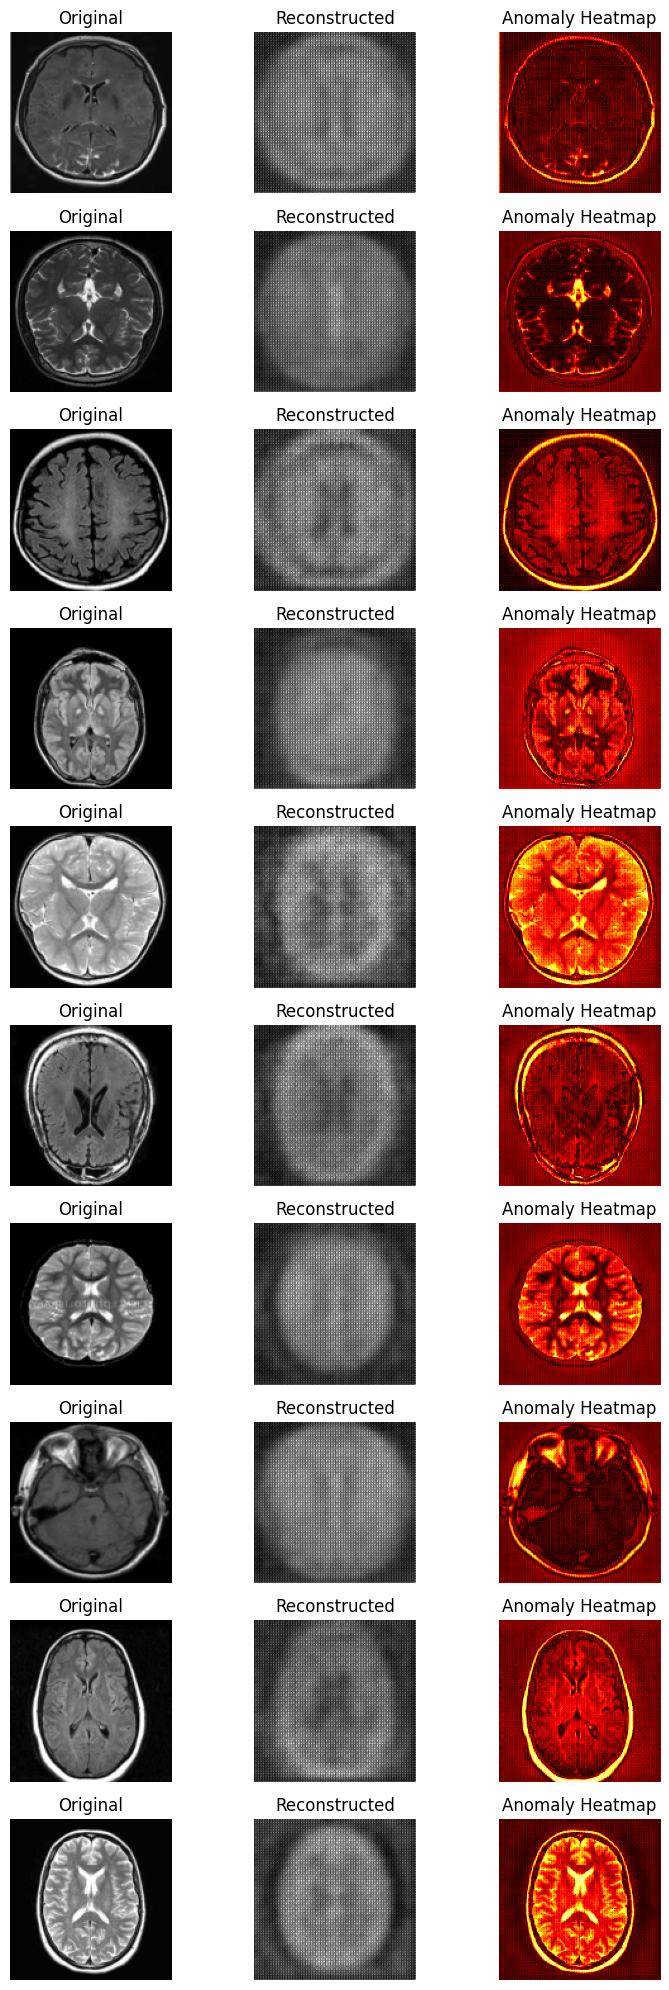

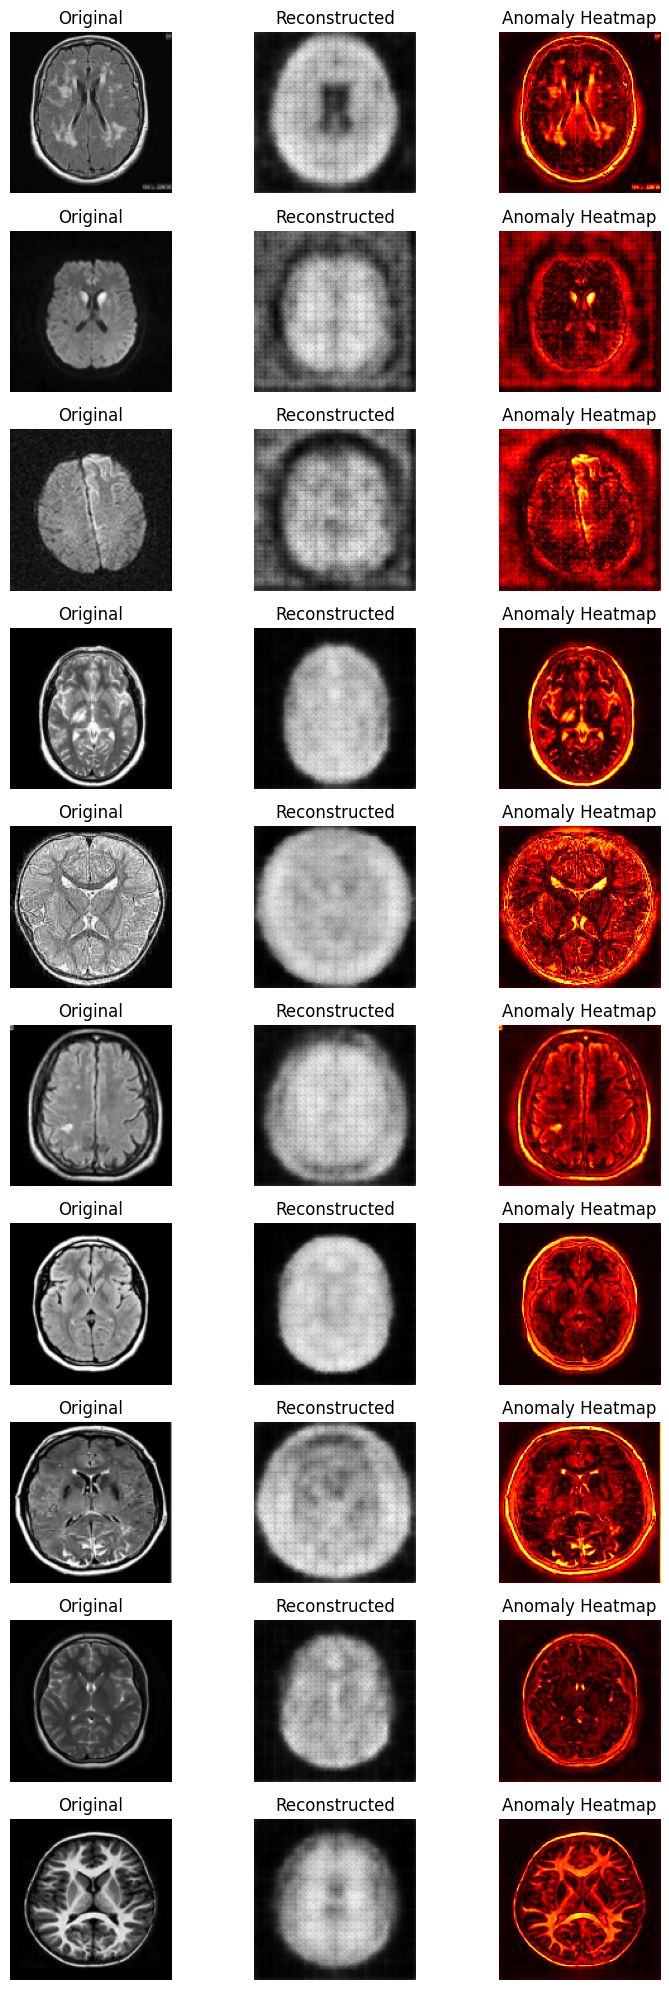

In [19]:
trained_model, history = train_model(model, no_tumor_data_loader, no_tumor_data_loader, criterion, optimizer, OUTPUT_DIR, num_epochs=NUM_EPOCHS+1, save_after_k=SAVE_AFTER_K, validate_after_k=VALIDATE_AFTER_K);